In [1]:
import numpy as np
import pandas as pd
import random
import string

from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, poisson

In [2]:
# city names
canada_cities = pd.read_csv('list-of-cities-in-canada-csv.csv',names=['city'])
canada_cities = list(canada_cities['city'])

#make of cars
car_make = [
    'honda',
    'toyota',
    'bmw',
    'mercedes',
    'ford',
    'gmc',
    'tesla',
    'chevy',
    'audi',
    'nissan',
    'acura',
]

model_dict = {
    'honda': ['civic', 'accord'],
    'toyota': ['camry', 'corrola'],
    'bmw': ['m3', 'i8', 'x5'],
    'mercedes': ['c', 's', 'g'],
    'ford': ['f150', 'focus', 'explorer'],
    'gmc': ['terrain','sierra','yukon'],
    'tesla': ['x', '3', 's'],
    'chevy': ['equinox', 'malibu'],
    'audi': ['r8','e-tron'],
    'nissan':['mirano','micro'],
    'acura':['rsx', 'mdx']
}


In [3]:
parameters = {'age':  sp_randint(18, 85),
              'city': canada_cities,
              'year': sp_randint(1998, 2020),
              'make': car_make,
              'dist': sp_randint(1200, 25000),
              'gender': ['m','f'],
              }

# other columns
    # new_used
    # model

p_list = list(ParameterSampler(parameters, n_iter=10,random_state=32))

In [4]:
df = pd.DataFrame(p_list)
df

,age,city,dist,gender,make,year
0,61,Belleville,10726,m,audi,2017
1,21,Wood Buffalo,9401,m,toyota,2001
2,83,Kelowna,9427,m,acura,2016
3,28,St. John,21090,m,ford,2003
4,56,Sarnia,7099,m,audi,2018
5,82,Burnaby,6942,m,ford,2007
6,48,Sherbrooke,11651,m,gmc,2008
7,53,Peterborough,23266,f,audi,2013
8,29,Vancouver,12383,f,bmw,2000
9,66,St. John,13954,f,acura,2000


In [5]:
def select_model_and_age(df, model_dict):
    model_list = []
    age_list = []
    
    for i in df.itertuples():
        if i.make in list(model_dict.keys()):
            model_ind = random.choice(model_dict[i.make])
            model_list.append(model_ind)
        else:
            model_list.append('other')
            
        if i.year > 2018:
            age_list.append('new')
        else:
            age_list.append('used')
            
        
    
        
            
    df['model'] = model_list
    df['new_used'] = age_list
    return df
    

In [6]:
df = select_model_and_age(df, model_dict)
df

,age,city,dist,gender,make,year,model,new_used
0,61,Belleville,10726,m,audi,2017,e-tron,used
1,21,Wood Buffalo,9401,m,toyota,2001,corrola,used
2,83,Kelowna,9427,m,acura,2016,mdx,used
3,28,St. John,21090,m,ford,2003,f150,used
4,56,Sarnia,7099,m,audi,2018,e-tron,used
5,82,Burnaby,6942,m,ford,2007,f150,used
6,48,Sherbrooke,11651,m,gmc,2008,terrain,used
7,53,Peterborough,23266,f,audi,2013,r8,used
8,29,Vancouver,12383,f,bmw,2000,x5,used
9,66,St. John,13954,f,acura,2000,rsx,used


In [8]:
def insurance_price(df, base_rate, weights):
    weight_age = weights['weight_age']
    weight_city = weights['weight_city']
    weight_year = weights['weight_year']
    weight_make = weights['weight_make']
    weight_dist = weights['weight_dist']
    weight_gender = weights['weight_gender']
    rate_age = weights['rate_age']
    rate_make = weights['rate_make']
    rate_city = weights['rate_city']
    rate_year = weights['rate_year']
    rate_dist = weights['rate_dist']
    rate_gender = weights['rate_gender']
    
    # cost = base_rate + (weight_age * rate_age * age / 100) + weight_city * rate_city * category_cost+
    # weight_make * rate_make * category_cost + (weight_dist * dist * rate_dist)/1000 + 
    # weight_gender * rate_gender
    l = []
    for i in df.itertuples():
        # age buckets
        if i.age < 30:
            age_category_cost = 100
        elif i.age >=30 < 65:
            age_category_cost = 20
        elif i.age >=65 < 75:
            age_category_cost = 40
        else:
            age_category_cost = 120
        
        # city buckets
        city_index = string.ascii_lowercase.index(i.city[0].lower())
        if city_index < 10:
            city_category_cost = 10
        elif city_index >=10 < 17:
            city_category_cost = 50
        else:
            city_category_cost = 80
            
        
        # make buckets
        if i.make in ['honda', 'toyota','gmc','nissan','ford','chevy']:
            make_category_cost = 50
        elif i.make in ['acura', 'tesla']:
            make_category_cost = 90
        elif i.make in ['mercedes','bmw', 'audi']:
            make_category_cost = 140
        else:
            make_category_cost = 60
            
        # gender buckets
        if i.gender == 'm':
            gender_category_cost = 100
        else:
            gender_category_cost = 50
        
        # distance buckets
        if i.dist <3000:
            dist_category_cost = 50
        elif i.dist >=3000 < 8000:
            dist_category_cost = 100
        else:
            dist_category_cost = 160

            
        # calculation for making the cost
        cost_total = (base_rate + (weight_age * age_category_cost) ** rate_age  + (weight_city * city_category_cost) ** rate_city + (weight_make * make_category_cost) ** rate_make + (weight_dist * dist_category_cost) ** rate_dist + (weight_gender * gender_category_cost) ** rate_gender)
                
        l.append(cost_total/12.0)
    df2 = df.copy()
    df2['quote'] = l
    return df2

In [9]:
weights = {
    "weight_age": 1.5,
    "weight_city": 0.5,
    "weight_year": 1.2,
    "weight_make": 0.7,
    "weight_dist": 2,
    "weight_gender": 1,
    "rate_age": 1.07,
    "rate_city": 2,
    "rate_make": 1.06,
    "rate_year": 1,
    "rate_dist": 1,
    "rate_gender": 1.04,
}

In [10]:
df_2 = insurance_price(df, 100, weights)
df_2.head()

,age,city,dist,gender,make,year,model,new_used,quote
0,61,Belleville,10726,m,audi,2017,e-tron,used,51.026964
1,21,Wood Buffalo,9401,m,toyota,2001,corrola,used,108.463955
2,83,Kelowna,9427,m,acura,2016,mdx,used,97.005865
3,28,St. John,21090,m,ford,2003,f150,used,108.463955
4,56,Sarnia,7099,m,audi,2018,e-tron,used,101.026964


In [11]:
df.head()

,age,city,dist,gender,make,year,model,new_used
0,61,Belleville,10726,m,audi,2017,e-tron,used
1,21,Wood Buffalo,9401,m,toyota,2001,corrola,used
2,83,Kelowna,9427,m,acura,2016,mdx,used
3,28,St. John,21090,m,ford,2003,f150,used
4,56,Sarnia,7099,m,audi,2018,e-tron,used


In [33]:
weight_params = {
    "weight_age": uniform(loc=1,scale=1.5),
    "weight_city": uniform(loc=1,scale=1.5),
    "weight_year": uniform(loc=1,scale=1.5),
    "weight_make": uniform(loc=1,scale=1.5),
    "weight_dist": uniform(loc=1,scale=1.5),
    "weight_gender": uniform(loc=1,scale=1.5),
    "rate_age": uniform(loc=0,scale=1.1),
    "rate_city": uniform(loc=0,scale=1.1),
    "rate_make": uniform(loc=1,scale=1.1),
    "rate_year": uniform(loc=0,scale=1.5),
    "rate_dist": uniform(loc=0,scale=1.1),
    "rate_gender": uniform(loc=0,scale=1.1),
}

weight_params_list = list(ParameterSampler(weight_params, n_iter=5,random_state=16))
weight_params_list

[{'rate_age': 0.24562018706889277,
  'rate_city': 0.5754796755407438,
  'rate_dist': 0.6057716022392993,
  'rate_gender': 0.05016214514608696,
  'rate_make': 1.39680171888255,
  'rate_year': 0.33462141253693317,
  'weight_age': 2.033089242732035,
  'weight_city': 1.2455971375013488,
  'weight_dist': 1.1054873002082504,
  'weight_gender': 2.411516290368754,
  'weight_make': 1.845522070352238,
  'weight_year': 1.1169885090849805},
 {'rate_age': 0.7949045622373239,
  'rate_city': 0.1742973908754831,
  'rate_dist': 0.27530943741842573,
  'rate_gender': 0.3228359817124173,
  'rate_make': 1.7662717856294545,
  'rate_year': 0.6963961320602277,
  'weight_age': 1.3225932155715092,
  'weight_city': 1.6702393931194863,
  'weight_dist': 1.1813181273084354,
  'weight_gender': 2.3765305116170876,
  'weight_make': 1.8496694930787934,
  'weight_year': 1.7080289736128909},
 {'rate_age': 0.3460230671119327,
  'rate_city': 0.04753730271028875,
  'rate_dist': 0.8276894086559704,
  'rate_gender': 0.5975959

In [38]:
weight_params_list[0]

{'rate_age': 0.24562018706889277,
 'rate_city': 0.5754796755407438,
 'rate_dist': 0.6057716022392993,
 'rate_gender': 0.05016214514608696,
 'rate_make': 1.39680171888255,
 'rate_year': 0.33462141253693317,
 'weight_age': 2.033089242732035,
 'weight_city': 1.2455971375013488,
 'weight_dist': 1.1054873002082504,
 'weight_gender': 2.411516290368754,
 'weight_make': 1.845522070352238,
 'weight_year': 1.1169885090849805}

In [36]:
df2 = insurance_price(df, 100, weight_params_list[2])
df2

,age,city,dist,gender,make,year,model,new_used,quote
0,61,Belleville,10726,m,audi,2017,e-tron,used,1948.275202
1,21,Wood Buffalo,9401,m,toyota,2001,corrola,used,304.502943
2,83,Kelowna,9427,m,acura,2016,mdx,used,870.831242
3,28,St. John,21090,m,ford,2003,f150,used,304.502943
4,56,Sarnia,7099,m,audi,2018,e-tron,used,1948.282840
5,82,Burnaby,6942,m,ford,2007,f150,used,304.313850
6,48,Sherbrooke,11651,m,gmc,2008,terrain,used,304.321488
7,53,Peterborough,23266,f,audi,2013,r8,used,1947.607006
8,29,Vancouver,12383,f,bmw,2000,x5,used,1947.788460
9,66,St. John,13954,f,acura,2000,rsx,used,870.155407


In [45]:
l = []
for i in weight_params_list:
    df2 = insurance_price(df, 100, i)
    a = df2['quote'].to_numpy()
    l.append(a)
l = np.array(l)

In [46]:
l

array([[ 205.54385206,   57.39837587,  116.24012239,   57.39837587,
         206.08638456,   56.755458  ,   57.2979905 ,  206.0826349 ,
         206.18302026,  116.23637272],
       [1535.23531014,  260.7709863 ,  709.15661221,  260.7709863 ,
        1535.27939083,  257.80574046,  257.84982115, 1535.18167155,
        1538.1028367 ,  709.05889293],
       [1948.27520177,  304.50294299,  870.83124186,  304.50294299,
        1948.2828399 ,  304.31384991,  304.32148803, 1947.60700552,
        1947.78846048,  870.15540748],
       [1261.02963291,  200.57257167,  564.87449904,  200.57257167,
        1262.86780296,  196.85556233,  198.69373238, 1262.8670304 ,
        1264.7458697 ,  564.87372648],
       [1522.65321637,  303.50540704,  732.65278169,  303.50540704,
        1522.73072996,  281.83444618,  281.91195977, 1522.72943678,
        1544.32288405,  732.65148851]])

In [47]:
df3 = pd.DataFrame(l.T)

In [48]:
df3

,0,1,2,3,4
0,205.543852,1535.235310,1948.275202,1261.029633,1522.653216
1,57.398376,260.770986,304.502943,200.572572,303.505407
2,116.240122,709.156612,870.831242,564.874499,732.652782
3,57.398376,260.770986,304.502943,200.572572,303.505407
4,206.086385,1535.279391,1948.282840,1262.867803,1522.730730
5,56.755458,257.805740,304.313850,196.855562,281.834446
6,57.297991,257.849821,304.321488,198.693732,281.911960
7,206.082635,1535.181672,1947.607006,1262.867030,1522.729437
8,206.183020,1538.102837,1947.788460,1264.745870,1544.322884
9,116.236373,709.058893,870.155407,564.873726,732.651489


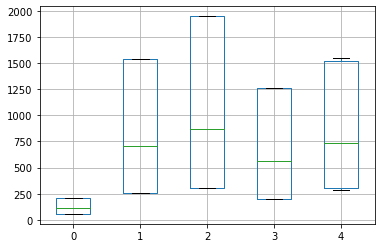

In [51]:
boxplot = df3.boxplot()